<a href="https://colab.research.google.com/github/Forcer0625/RL/blob/main/EasyRL_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Q-Learning策略

In [8]:
import numpy as np
import math
import torch
from collections import defaultdict

# 建立Q-learning的策略(agent)
class QLearning(object):
    def __init__(self,n_states,
                 n_actions,cfg):
        self.n_actions = n_actions 
        self.lr = cfg.lr  # 學習率，hyperparameter
        self.gamma = cfg.gamma  
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存狀態->動作->狀態->動作值（即Q值）的映射，到Q-Table
    def sample(self, state):
        """訓練時用的採樣動作"""
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是會遞減的，這裡使用指數遞減
        # e-greedy 策略(有e的機率選擇目前最佳動作)
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 選擇Q(s, a)最大，對應的動作
        else:
            action = np.random.choice(self.n_actions) # 隨機選擇動作
        return action
    def predict(self,state):
        """測試時用的預測/選擇動作"""
        action = np.argmax(self.Q_table[str(state)]) # Q-Learning:直接取最大值
        return action
    def update(self, state, action, reward, next_state, done):
        Q_predict = self.Q_table[str(state)][action] 
        if done: # 終止狀態
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)
    def save(self,path):
        import dill
        torch.save(
            obj=self.Q_table,
            f=path+"Qleaning_model.pkl",
            pickle_module=dill
        )
        print("模型儲存成功！")
    def load(self, path):
        import dill
        self.Q_table =torch.load(f=path+'Qleaning_model.pkl',pickle_module=dill)
        print("模型載入成功！")

## 2. 環境(Q-learning太弱了，需要足夠簡單的環境)

In [6]:
import gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

def GridWorld(gridmap=None, is_slippery=False):
    if gridmap is None:
        gridmap = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
    env = gym.make("FrozenLake-v0", desc=gridmap, is_slippery=False)
    env = FrozenLakeWapper(env)
    return env
    
class FrozenLakeWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.max_y = env.desc.shape[0]
        self.max_x = env.desc.shape[1]
        self.t = None
        self.unit = 50

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for _ in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for i in range(self.desc.shape[0]):
                for j in range(self.desc.shape[1]):
                    x = j
                    y = self.max_y - 1 - i
                    if self.desc[i][j] == b'S':  # Start
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'F':  # Frozen ice
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'G':  # Goal
                        self.draw_box(x, y, 'yellow')
                    elif self.desc[i][j] == b'H':  # Hole
                        self.draw_box(x, y, 'black')
                    else:
                        self.draw_box(x, y, 'white')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

## 3.定義訓練參數

In [10]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 獲取目前時間
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='Q-learning',type=str,help="name of algorithm") # 訓練演算法的名稱:Q-learning
    parser.add_argument('--env_name',default='CliffWalking-v0',type=str,help="name of environment") # 訓練環境(預設為CliffWalking-v0)
    parser.add_argument('--train_eps',default=400,type=int,help="episodes of training") # 訓練的回合數
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 測試的回合數
    parser.add_argument('--gamma',default=0.90,type=float,help="discounted factor") # discounted factor
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon") #  e-greedy策略中的初始epsilon
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon") # e-greedy策略中的终止epsilon
    parser.add_argument('--epsilon_decay',default=300,type=int,help="decay rate of epsilon") # e-greedy策略中epsilon的遞減率
    parser.add_argument('--lr',default=0.1,type=float,help="learning rate") # 學習率
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") # 使用的裝置(預設為CPU)         
    args = parser.parse_args([])                          
    return args
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 獲取目前時間

In [17]:
import gym

# 初始化環境
env = gym.make("CliffWalking-v0")  # 0 up, 1 right, 2 down, 3 left
env = CliffWalkingWapper(env)
# 取得訓練相關參數
cfg = get_args()
agent = QLearning(
    n_states=env.observation_space.n,
    n_actions=env.action_space.n, cfg=cfg)
rewards = []
ma_rewards = [] # moving average reward
for i_ep in range(cfg.train_eps): # train_eps: 訓練的最大episodes數
    ep_reward = 0  # 記錄每个episode的reward
    state = env.reset()  # 重製環境, 重新開始新的一局（即開始新的episode）
    while True:
        action = agent.sample(state)  # 根據演算法選擇一個動作
        next_state, reward, done, _ = env.step(action)  # 透過選擇的動作與環境互動
        agent.update(state, action, reward, next_state, done)  # Q-learning更新
        state = next_state  # 儲存上一個狀態值
        ep_reward += reward
        if done:
            break
    rewards.append(ep_reward)
    if ma_rewards:
        ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
    else:
        ma_rewards.append(ep_reward)
    print("Episode:{}/{}: reward:{:.1f}".format(i_ep+1, cfg.train_eps,ep_reward))


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Episode:1/400: reward:-1854.0
Episode:2/400: reward:-1652.0
Episode:3/400: reward:-324.0
Episode:4/400: reward:-289.0
Episode:5/400: reward:-267.0
Episode:6/400: reward:-149.0
Episode:7/400: reward:-270.0
Episode:8/400: reward:-115.0
Episode:9/400: reward:-103.0
Episode:10/400: reward:-339.0
Episode:11/400: reward:-320.0
Episode:12/400: reward:-190.0
Episode:13/400: reward:-59.0
Episode:14/400: reward:-114.0
Episode:15/400: reward:-98.0
Episode:16/400: reward:-99.0
Episode:17/400: reward:-186.0
Episode:18/400: reward:-29.0
Episode:19/400: reward:-114.0
Episode:20/400: reward:-56.0
Episode:21/400: reward:-148.0
Episode:22/400: reward:-83.0
Episode:23/400: reward:-77.0
Episode:24/400: reward:-122.0
Episode:25/400: reward:-74.0
Episode:26/400: reward:-177.0
Episode:27/400: reward:-126.0
Episode:28/400: reward:-71.0
Episode:29/400: reward:-75.0
Episode:30/400: reward:-106.0
Episode:31/400: reward:-31.0
Episode:32/400: reward:-61.0
Episode:33/400: reward:-97.0
Episode:34/400: reward:-112.0


## 5.檢視訓練結果

In [ ]:
def smooth(data, weight=0.9):  
    """用於平滑曲線，類似於tensorboard中的smooth

    Args:
        data (List):輸入資料
        weight (Float): 平滑權重，界於0~1之間，值越高越平滑(一般取0.9)

    Returns:
        smoothed (List):平滑後的資料
    """
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 計算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

# 渲染出reward的成長曲線
def plot_rewards(rewards,cfg, tag='train'):
    sns.set()
    plt.figure()
    plt.title("learning curve on {} of {} for {}".format(
        cfg.device, cfg.algo_name, cfg.env_name))
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

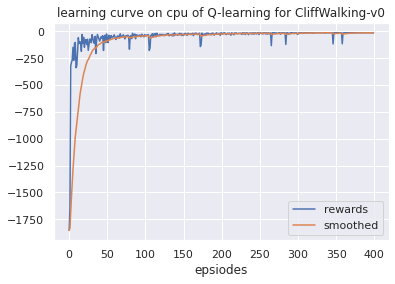

In [18]:
plot_rewards(rewards, cfg, tag="test")